In [48]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
import gcsfs
import fsspec
import xesmf as xe
import warnings
warnings.filterwarnings('ignore')
# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
col_url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(col_url)

In [3]:
pd.set_option('display.max_rows', 250) # so that we can see all of the different experiments available

In [4]:
 # Different variable options : 
#'mrro' - runoff
#'snw' - SWE
 #hfls - latent heat
 # mrros - surface runoff
 # mrso - soil moisture
 # pr - precipitation
 # tas - mean daily air temperature
 # prra - rainfall rate
 # prsn - snowfall rate

variable_of_interest = 'mrro'

In [5]:
cat = col.search(experiment_id=['ssp585', 'historical', 'ssp126', 'ssp245', 'ssp370'],#, 'historical'], 
                 table_id='day',             
                 variable_id=variable_of_interest) 
# this is a hack just to get around the different grid_label strings
cat.df['grid_label']='gn'

In [32]:
future_slice = slice('2070','2099')
historical_slice = slice('1985','2014')

In [7]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False})

ds_dict = {}
for name, ds in tqdm(dset_dict.items()):
    # rename spatial dimensions if necessary
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'}) # some models labelled dimensions differently...
    ds = xr.decode_cf(ds) # temporary hack, not sure why I need this but has to do with calendar-aware metadata on the time variable
#     ds = ds.sel(time=time_slice) # subset the data for the time period of interest
    
    # drop redundant variables (like "height: 2m")
    for coord in ds.coords:
        if coord not in ['lat','lon','time']:
            ds = ds.drop(coord)
    
    # Add dataset to dictionary, selecting first member_id for each simulation since we'll just use
    # one ensemble member right now
    ds_dict[name] = ds.isel(member_id=0)

Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 61 group(s)


In [15]:
def calculate_change(historic, future, percentage=True):
    if percentage:
        return (future - historic)/(historic) * 100
    else:
        return future - historic

In [16]:
def annual_mean(ts):
    return ts.mean(dim='time')

In [26]:
def stdev(ts, freq='monthly'):
    if freq == 'monthly':
        return ts.resample(time='M').mean().std(dim='time')
    else:
        print('calculating daily')
        return ts.std(dim='time')

In [18]:
def low_runoff(ts):
    return ts.resample(time='M').mean().groupby('time.year').min().min(dim='year')

In [19]:
def plot_nicely(ax, ds, vmin, vmax, cmap='viridis', cbar_label=None, title=None):
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, color='lightgrey')
    ax.add_feature(cartopy.feature.OCEAN, color='grey')
    # plot.contourf(ax=ax, levels=n.arange(min_var, max_var, interval))
    ds.plot(ax=ax, transform=ccrs.PlateCarree(),
            vmin=vmin, vmax=vmax, cmap=cmap, 
            levels=np.arange(vmin,vmax,np.float((vmax-vmin)/10)),
           cbar_kwargs={'label': cbar_label})
    ax.set_title(title)

    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-')


# load and regrid to a common grid

In [20]:
def calculate_qflow(da, rolling_period=30, minimum=True):
    '''calculate n-day (based upon rolling_period) moving average.
    if minimum, returns the minimum value in the 30 year period
    if not, returns the average'''
    if minimum:
        return da.rolling(time=rolling_period, 
                          center=True).mean().groupby('time.year').min().min(dim='year')
    else:
        return da.rolling(time=rolling_period, 
                          center=True).mean().groupby('time.year').min().mean(dim='year')

In [21]:
def variability(da):
    return da.resample(time='M').mean().std(dim='time')

In [ ]:
# specify the common grid based upon one of the higher resolution grids
common_grid_ds = xr.Dataset({'lat': (['lat'], ds_dict['CMIP.NCAR.CESM2.historical.day.gn'].lat.values),
                     'lon': (['lon'], ds_dict['CMIP.NCAR.CESM2.historical.day.gn'].lon.values)},)

function= variability # low_runoff #calculate_qflow

regrid=False
change_dict = {}
for source_id in set(cat.df['source_id']):
    institution_id = list(set(cat.df['institution_id'][cat.df['source_id']==source_id].values))[0]
    # remove the scenarios that don't have historical
    if institution_id in ['EC-Earth-Consortium', 'CNRM-CERFACS'] or \
        source_id in ['GFDL-ESM4', 'HadGEM3-GC31-LL', 'BCC-ESM1',
                      'MIROC-ES2L', 'SAM0-UNICON', 'MPI-ESM1-2-HR']:
#         source_id in ['GFDL-CM4', 'CanESM5', 'IPSL-CM6A', 'KACE-1-0-G',
#                      'UKESM1-0-LL', 'IPSL-CM6A-LR', # these are done
#                       'BCC-CSM2-MR']: # these broke 
        continue
    # select future and historical periods
    print('here!')
    working_ds_historical = ds_dict['CMIP.{}.{}.historical.day.gn'.format(institution_id, 
                                    source_id)][variable_of_interest].sel(time=historical_slice).chunk(
                                chunks={'lat': 100, 'lon': -1, 'time': 1000})
    print('here!')
    working_ds_future = ds_dict['ScenarioMIP.{}.{}.ssp585.day.gn'.format(institution_id, 
                                    source_id)][variable_of_interest].sel(time=future_slice).chunk(
                                chunks={'lat': 100, 'lon': -1, 'time': 1000})
    
    # make the regridder for these files
    # TODO: fix the 'lon_b' inputs to allow use of conservative remapping

    if regrid:
        regridder = xe.Regridder(working_ds_historical, common_grid_ds,
                                 'bilinear', reuse_weights=True)     

        change_dict[source_id] = calculate_change(function(regridder(working_ds_historical)), 
                                                  function(regridder(working_ds_future)))

    else:
        change_dict[source_id] = calculate_change(function(working_ds_historical), 
                                                  function(working_ds_future))
        change_dict[source_id].to_netcdf('change_{}_1970s_2070s_variability.nc'.format(source_id))
        print(source_id)
    
# combine all data arrays in the dictionary into a single dataset

here!
here!


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-b4e50a366b9c>", line 42, in <module>
    change_dict[source_id].to_netcdf('change_{}_1970s_2070s_variability.nc'.format(source_id))
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/dataarray.py", line 2334, in to_netcdf
    return dataset.to_netcdf(*args, **kwargs)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/dataset.py", line 1547, in to_netcdf
    invalid_netcdf=invalid_netcdf,
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/api.py", line 1081, in to_netcdf
    writes = writer.sync(compute=compute)
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/backends/common.py", line 204, in sync
    regions=self.regions,
  File "/srv/conda/envs/notebook/lib/python3.7

KeyboardInterrupt: 

In [14]:
change_ds = xr.concat([change_dict[key] for key in change_dict.keys()], 
                      pd.Index(change_dict.keys(), name='gcm')).chunk(chunks=15)

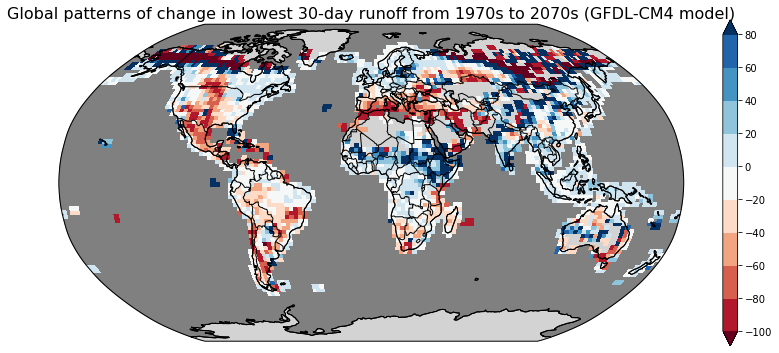

In [31]:
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(14,6),
                          subplot_kw=dict(projection=ccrs.Robinson()))
ax = axarr
ax.set_global()
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, color='lightgrey')
ax.add_feature(cartopy.feature.OCEAN, color='grey')
# plot.contourf(ax=ax, levels=n.arange(min_var, max_var, interval))
q = change.plot(ax=ax, transform=ccrs.PlateCarree(),
#                )#
                        vmin=-100, vmax=100, cmap='RdBu', levels=np.arange(-100,100,20))

ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
plt.title('Global patterns of change in lowest 30-day runoff from 1970s to 2070s (GFDL-CM4 model)',fontsize=16, ha='center');
plt.savefig('../figures/future_30q30_runoff_changes.png',dpi=100,bbox_inches='tight')

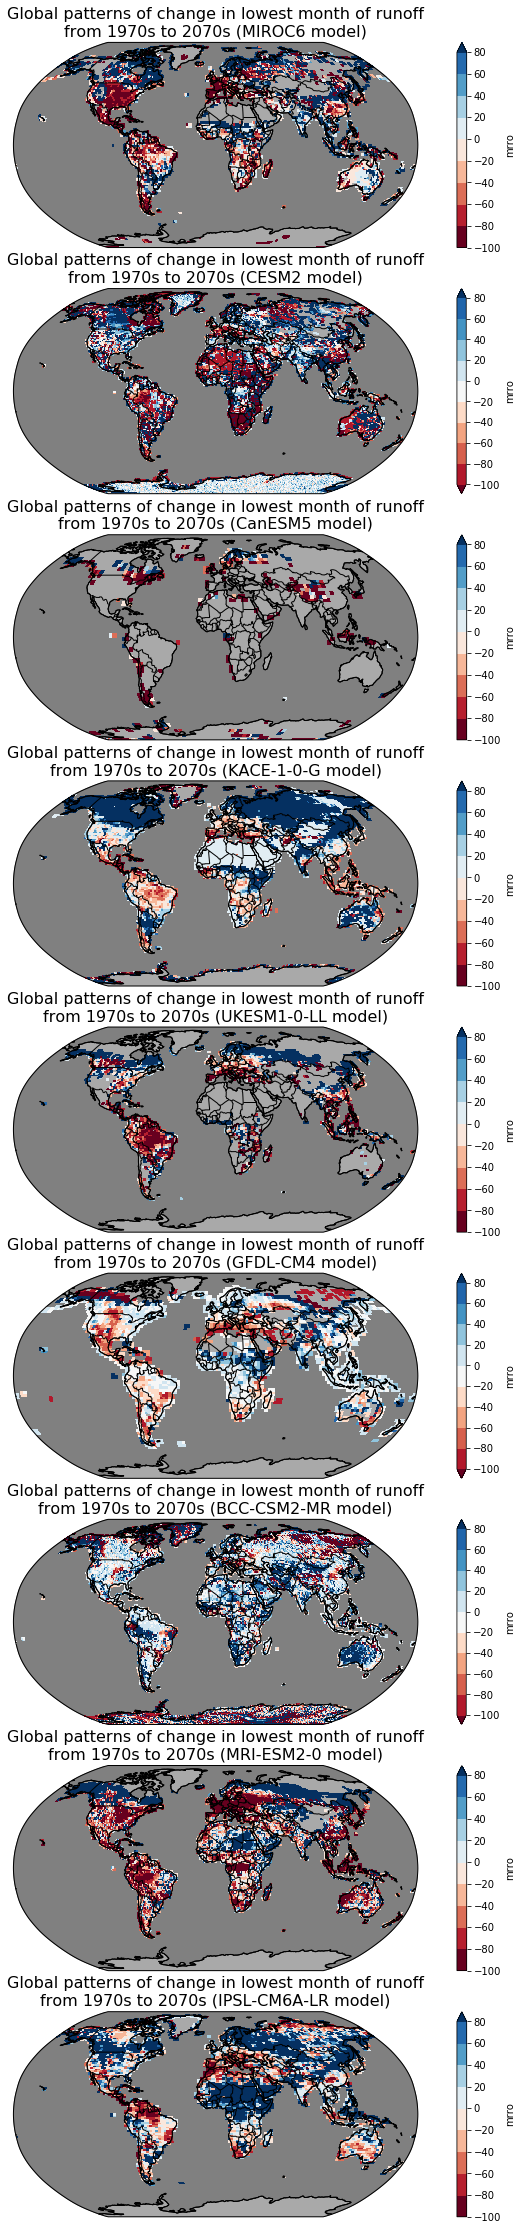

In [24]:
fig, axarr = plt.subplots(nrows=9, ncols=1, figsize=(14,40),
                          subplot_kw=dict(projection=ccrs.Robinson()))
for i, (gcm, change) in enumerate(change_dict.items()):
    ax = axarr[i]
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, color='darkgrey')
    ax.add_feature(cartopy.feature.OCEAN, color='grey')
    # plot.contourf(ax=ax, levels=n.arange(min_var, max_var, interval))
    q = change.plot(ax=ax, transform=ccrs.PlateCarree(),
    #                )#
                            vmin=-100, vmax=100, cmap='RdBu', levels=np.arange(-100,100,20))

    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
    ax.set_title('Global patterns of change in lowest month of runoff\nfrom 1970s to 2070s ({} model)'.format(gcm),fontsize=16, ha='center');
plt.savefig('../figures/future_30q30_runoff_changes.png',dpi=300,bbox_inches='tight')

* plot of low period
* plot of historical/future standard deviation of total runoff
* change in standard deviation
* plot of change in lowest month

# Change in standard deviation of runoff
### Standard deviation of future period minus stdev of past

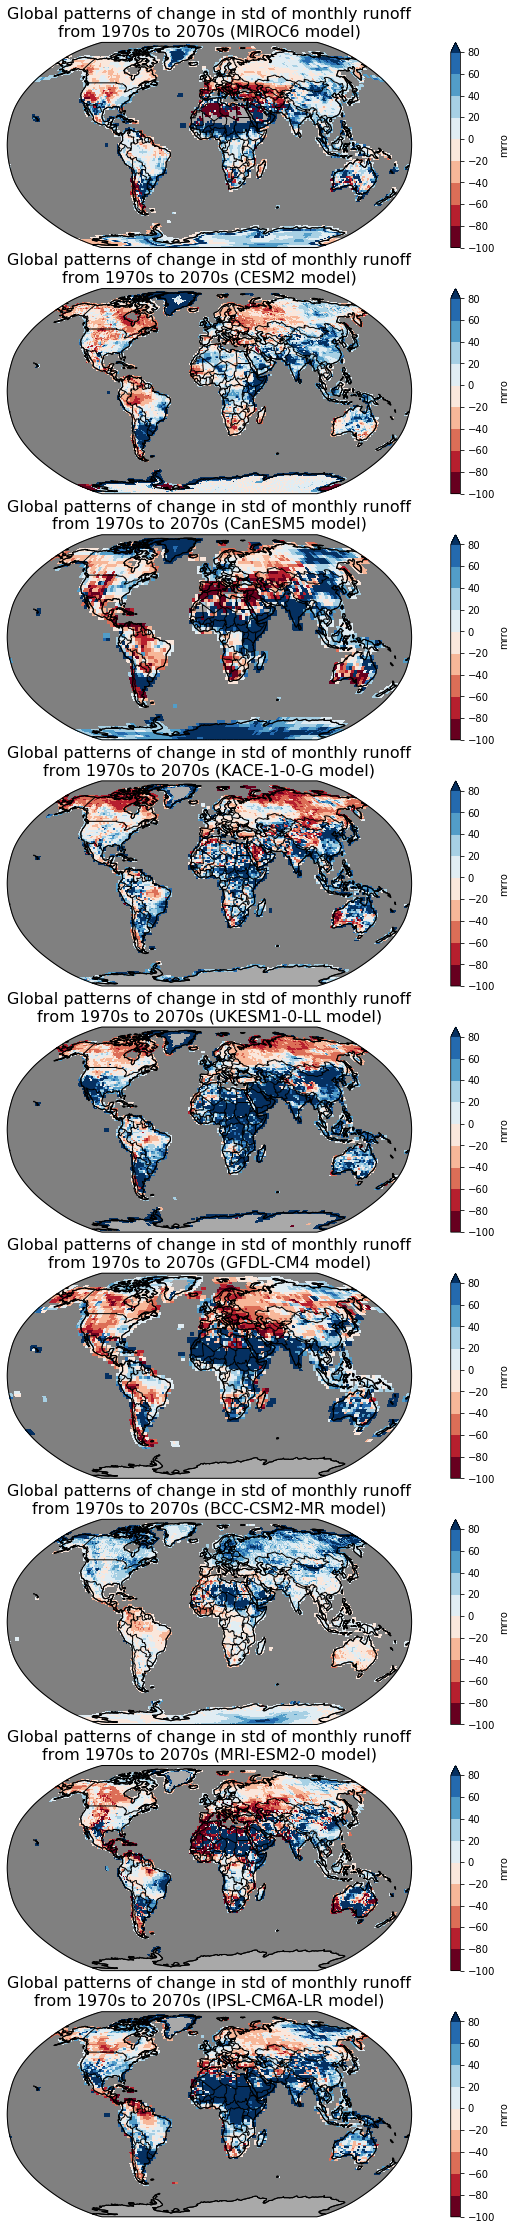

In [37]:
fig, axarr = plt.subplots(nrows=9, ncols=1, figsize=(14,40),
                          subplot_kw=dict(projection=ccrs.Robinson()))
for i, (gcm, change) in enumerate(change_dict.items()):
    ax = axarr[i]
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAND, color='darkgrey')
    ax.add_feature(cartopy.feature.OCEAN, color='grey')
    # plot.contourf(ax=ax, levels=n.arange(min_var, max_var, interval))
    q = change.plot(ax=ax, transform=ccrs.PlateCarree(),
    #                )#
                            vmin=-100, vmax=100, cmap='RdBu', levels=np.arange(-100,100,20))

    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
    ax.set_title('Global patterns of change in std of monthly runoff\nfrom 1970s to 2070s ({} model)'.format(gcm),fontsize=16, ha='center');
plt.savefig('../figures/future_std_monthly_runoff_changes.png',dpi=300,bbox_inches='tight')

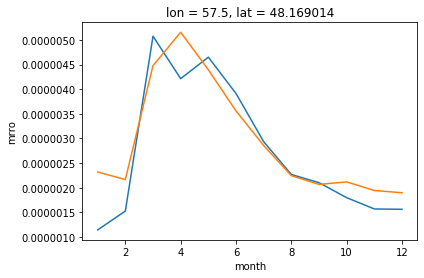

In [34]:
runoff_historical.sel(lat=48, lon=58, method='nearest').groupby('time.month').mean().plot()
runoff_future.sel(lat=48, lon=58, method='nearest').groupby('time.month').mean().plot()

# Pull in ERA data to understand biases

In [13]:
# specify the common grid based upon one of the higher resolution grids


In [ ]:
reload=True
if reload:
    ds_era = xr.open_zarr(fsspec.get_mapper('gcs://pangeo-era5/reanalysis/spatial-analysis'),
                  consolidated=True,
                  chunks='auto')
    common_grid_ds = xr.Dataset({'lat': (['lat'], ds_dict['CMIP.NCAR.CESM2.historical.day.gn'].lat.values),
                     'lon': (['lon'], ds_dict['CMIP.NCAR.CESM2.historical.day.gn'].lon.values)},)

    ds_era = ds_era.rename({'latitude': 'lat', 'longitude': 'lon'}).sel(time=slice('1985','2014'))
    regridder = xe.Regridder(ds_era, common_grid_ds, 'bilinear', reuse_weights=True)
    era_monthly_runoff = ds_era.resample(time='M').mean()
    era_monthly_runoff_stdev = regridder(era_monthly_runoff.ro.std(dim='time'))
    era_monthly_runoff_stdev.to_netcdf('era_monthly_runoff_stdev.nc')
    era_mean_runoff = regridder(ds_era.ro.mean(dim='time'))
    era_mean_runoff.to_netcdf('era_runoff_mean.nc')
else:
    era_monthly_runoff_stdev = xr.open_dataset('era_monthly_runoff_stdev.nc')
    era_mean_runoff = xr.open_dataset('era_runoff_mean.nc')

here
Reuse existing file: bilinear_721x1440_192x288.nc
here!
here


In [23]:
land_mask = ds_dict['CMIP.NCAR.CESM2.historical.day.gn'].mrro.isel(time=1)

# Historical ERA5 runoff

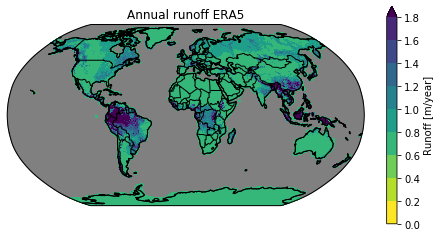

In [56]:
fig, axarr = plt.subplots(figsize=(8,4),
                          subplot_kw=dict(projection=ccrs.Robinson()))
plot_nicely(axarr, era_mean_runoff.ro.where(~np.isnan(land_mask))*365*24, 
            vmin=0, vmax=2, cmap='viridis_r',
           cbar_label='Runoff [m/year]', title='Annual runoff ERA5')
fig.savefig('../figures/era5_runoff.png', dpi=200)

In [ ]:
fig, axarr = plt.subplots(figsize=(8,4),
                          subplot_kw=dict(projection=ccrs.Robinson()))
plot_nicely(axarr, era_mean_runoff.ro.where(~np.isnan(land_mask))*365*24, 
            vmin=0, vmax=2, cmap='viridis_r',
           cbar_label='Runoff [m/year]', title='Annual std. dev. runoff ERA5')
fig.savefig('../figures/era5_runoff_stdev.png', dpi=200)

# Calculate performance of GCMs over historical for runoff

In [38]:
# specify the common grid based upon one of the higher resolution grids
common_grid_ds = xr.Dataset({'lat': (['lat'], ds_dict['CMIP.NCAR.CESM2.historical.day.gn'].lat.values),
                     'lon': (['lon'], ds_dict['CMIP.NCAR.CESM2.historical.day.gn'].lon.values)},)
regrid=True
regridded_dict = {'mean': {},
                 'stdev': {}}
for source_id in set(cat.df['source_id']):
    institution_id = list(set(cat.df['institution_id'][cat.df['source_id']==source_id].values))[0]
    # remove the scenarios that don't have historical
    if institution_id in ['EC-Earth-Consortium', 'CNRM-CERFACS'] or \
        source_id in ['GFDL-ESM4', 'HadGEM3-GC31-LL', 'BCC-ESM1',
                      'MIROC-ES2L', 'SAM0-UNICON', 'MPI-ESM1-2-HR']:
        continue
    # select historical period for comparison
    working_ds_historical = ds_dict['CMIP.{}.{}.historical.day.gn'.format(institution_id, 
                                    source_id)][variable_of_interest].sel(time=historical_slice).chunk(
                                chunks={'lat': -1, 'lon': -1, 'time': 1000})
    # make the regridder for these files
    # TODO: fix the 'lon_b' inputs to allow use of conservative remapping

    if regrid:
        regridder = xe.Regridder(working_ds_historical, common_grid_ds,
                                 'bilinear', reuse_weights=True)     

        regridded_dict['mean'][source_id] = regridder(annual_mean(working_ds_historical)).compute()
        regridded_dict['stdev'][source_id] = regridder(stdev(working_ds_historical)).compute()

mean_ds = xr.concat([regridded_dict['mean'][key] for key in regridded_dict['mean'].keys()], 
                      pd.Index(regridded_dict['mean'].keys(), name='gcm')).chunk(chunks=15)
stdev_ds = xr.concat([regridded_dict['stdev'][key] for key in regridded_dict['stdev'].keys()], 
                      pd.Index(regridded_dict['stdev'].keys(), name='gcm')).chunk(chunks=15)
historical_ds = xr.concat([mean_ds, stdev_ds], pd.Index(['mean', 'stdev'], name='metric'))

    
# combine all data arrays in the dictionary into a single dataset

Reuse existing file: bilinear_128x256_192x288.nc
Reuse existing file: bilinear_64x128_192x288.nc
Reuse existing file: bilinear_160x320_192x288.nc
Reuse existing file: bilinear_143x144_192x288.nc
Reuse existing file: bilinear_90x144_192x288.nc
Reuse existing file: bilinear_160x320_192x288.nc
Reuse existing file: bilinear_144x192_192x288.nc
Reuse existing file: bilinear_144x192_192x288.nc
Reuse existing file: bilinear_192x288_192x288.nc


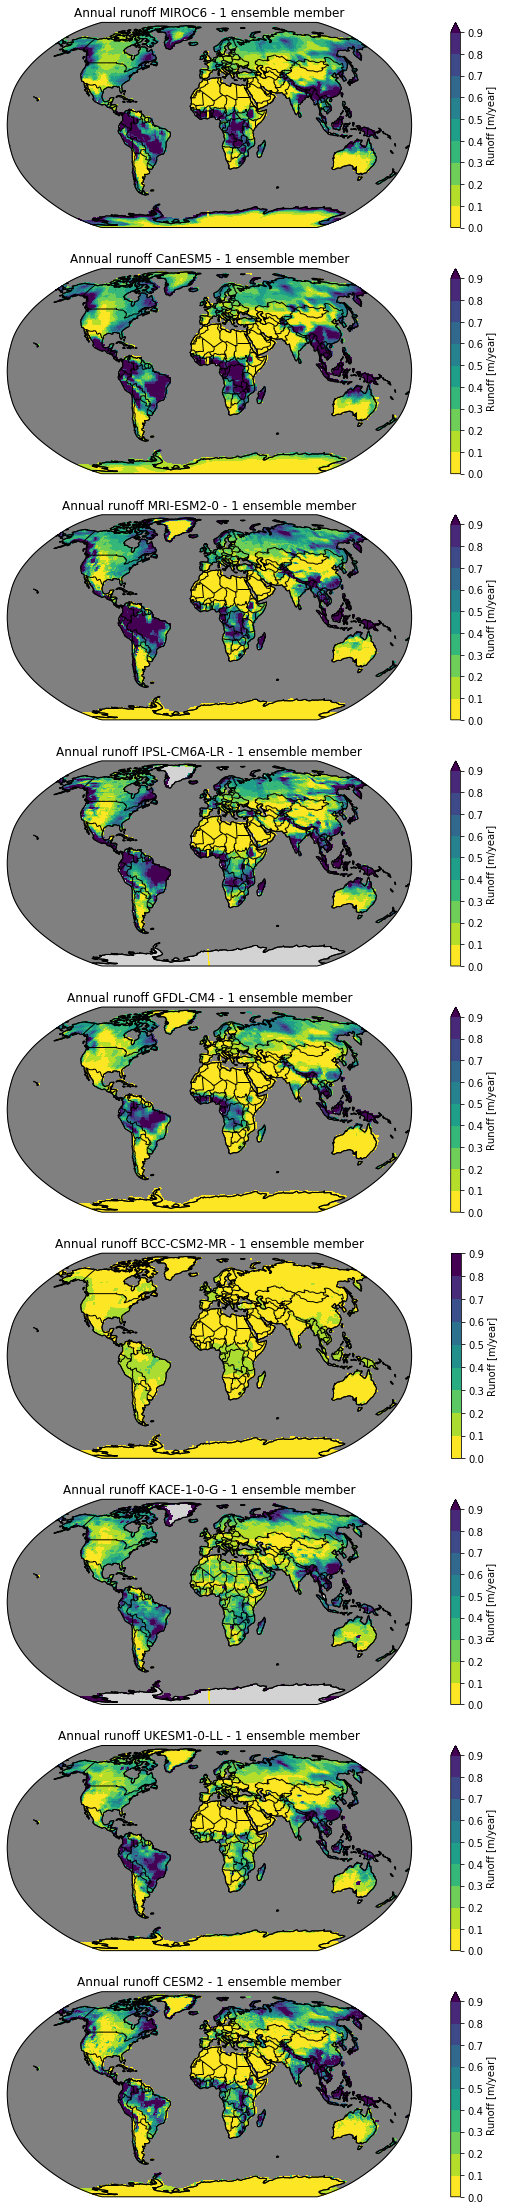

In [66]:
fig, axarr = plt.subplots(nrows=9, figsize=(14,40),
                          subplot_kw=dict(projection=ccrs.Robinson()))
for i, gcm in enumerate(historical_ds.gcm.values):
    plot_nicely(axarr[i], (historical_ds.sel(gcm=gcm).where(
        ~np.isnan(historical_ds.sel(gcm='CESM2')))*86400*365/1000).sel(metric='stdev'), 
                vmin=0, vmax=1, cmap='viridis_r',
               cbar_label='Std. deviation monthly runoff [m]', 
                title='Variability in monthly runoff {} - 1 ensemble member'.format(gcm))
fig.savefig('../figures/gcm_runoff_stdev.png', dpi=200)

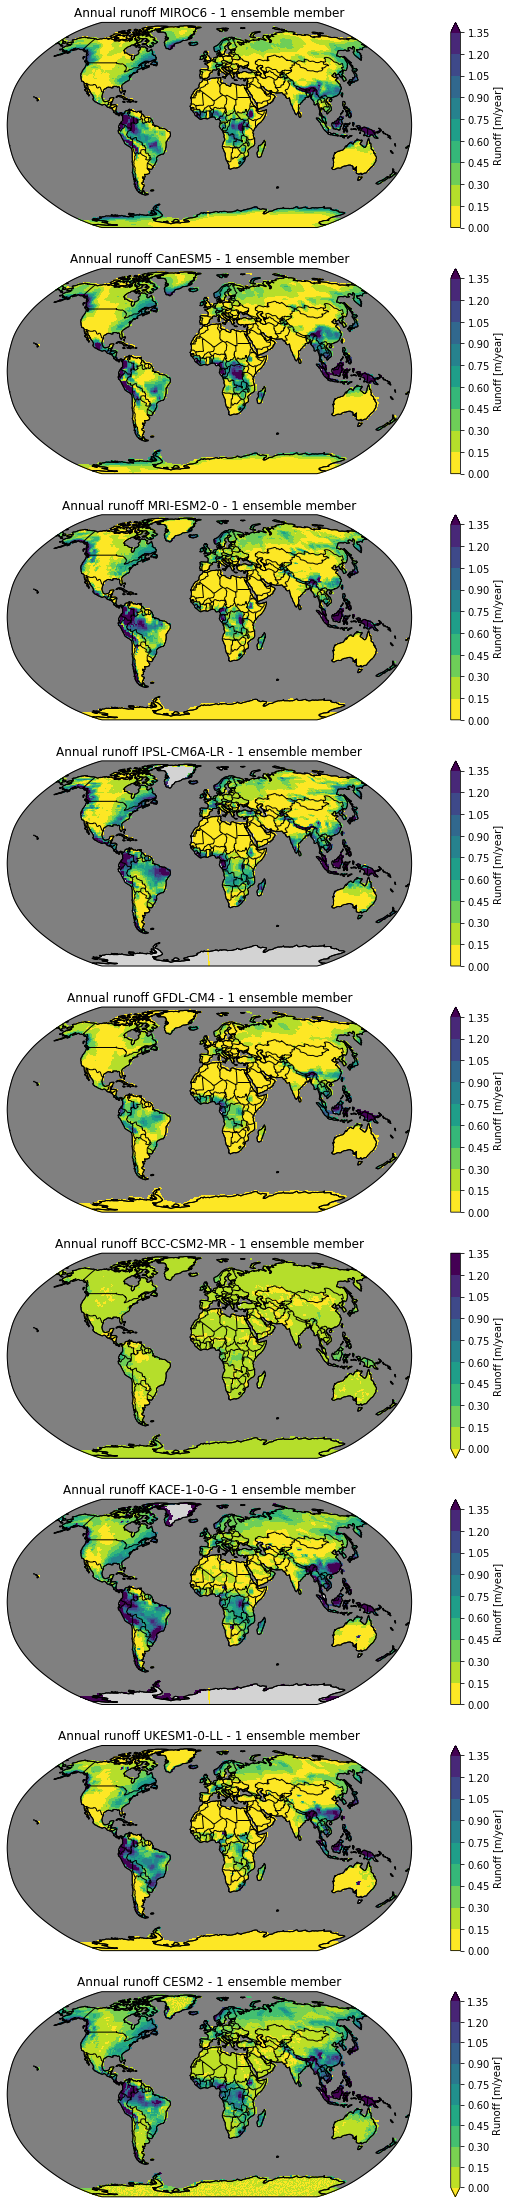

In [67]:
fig, axarr = plt.subplots(nrows=9, figsize=(14,40),
                          subplot_kw=dict(projection=ccrs.Robinson()))
for i, gcm in enumerate(historical_ds.gcm.values):
    plot_nicely(axarr[i], (historical_ds.sel(gcm=gcm).where(
        ~np.isnan(historical_ds.sel(gcm='CESM2')))*86400*365/1000).sel(metric='mean'), 
                vmin=0, vmax=1.5, cmap='viridis_r',
               cbar_label='Runoff [m/year]', title='Annual runoff {} - 1 ensemble member'.format(gcm))
fig.savefig('../figures/gcm_runoff.png', dpi=200)

In [7]:
for source_id in set(cat.df['source_id']):
    institution_id = list(set(cat.df['institution_id'][cat.df['source_id']==source_id].values))[0]
    # remove the scenarios that don't have historical
    if institution_id in ['EC-Earth-Consortium', 'CNRM-CERFACS'] or \
        source_id in ['GFDL-ESM4', 'HadGEM3-GC31-LL', 'BCC-ESM1',
                      'MIROC-ES2L', 'SAM0-UNICON', 'MPI-ESM1-2-HR']:
        continue
    working_ds_historical = ds_dict['CMIP.{}.{}.historical.day.gn'.format(institution_id, 
                                    source_id)][variable_of_interest].sel(time=historical_slice).chunk(
                                chunks={'lat': 100, 'lon': -1, 'time': 1000})
    if regrid:
        regridder = xe.Regridder(working_ds_historical, common_grid_ds,
                                 'bilinear', reuse_weights=True)     

        calculate_change(function(regridder(working_ds_historical)), 
                                                  function(regridder(working_ds_future)))

NameError: name 'ds_dict' is not defined

AttributeError: 'numpy.ndarray' object has no attribute 'set_global'

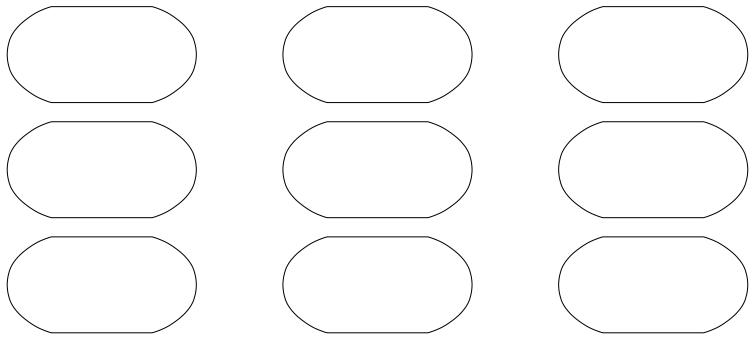

In [206]:
fig, axarr = plt.subplots(nrows=3, ncols=3, figsize=(14,6),
                          subplot_kw=dict(projection=ccrs.Robinson()))
for (i, source_id) in enumerate(change_dict.keys()):
    ax = axarr[i]
    ax.set_global()
    ax.coastlines()
    q = change_ds.sel(gcm=gcm).plot(ax=ax, 
                                    transform=ccrs.PlateCarree(), 
                                    vmin=-100, vmax=100, 
                                    cmap='RdBu', add_colorbar=False) # plot a colormap in transformed coordinates

    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
    plt.title('Patterns of global annual runnof change',fontsize=16, ha='center');
    # plt.savefig('../figures/future_runoff_changes.png',dpi=100,bbox_inches='tight')

#To-do list
* seasonal cycle (daily average for an average year within historical and future periods)
* function for each of these temporal metrics:
1. change in centroid of timing
1. change in lowest 30 day period magnitude
1. total deviation from the mean
1. duration of low flow
* function for each of these spatiotemporal metrics:
1. within a given basin what is the variability - to-do in this is figureing out shapefile masking for river basins

# metrics
- days below a threshold - maybe 10th percentile (xclim)
